Mean average precision: 0.9066


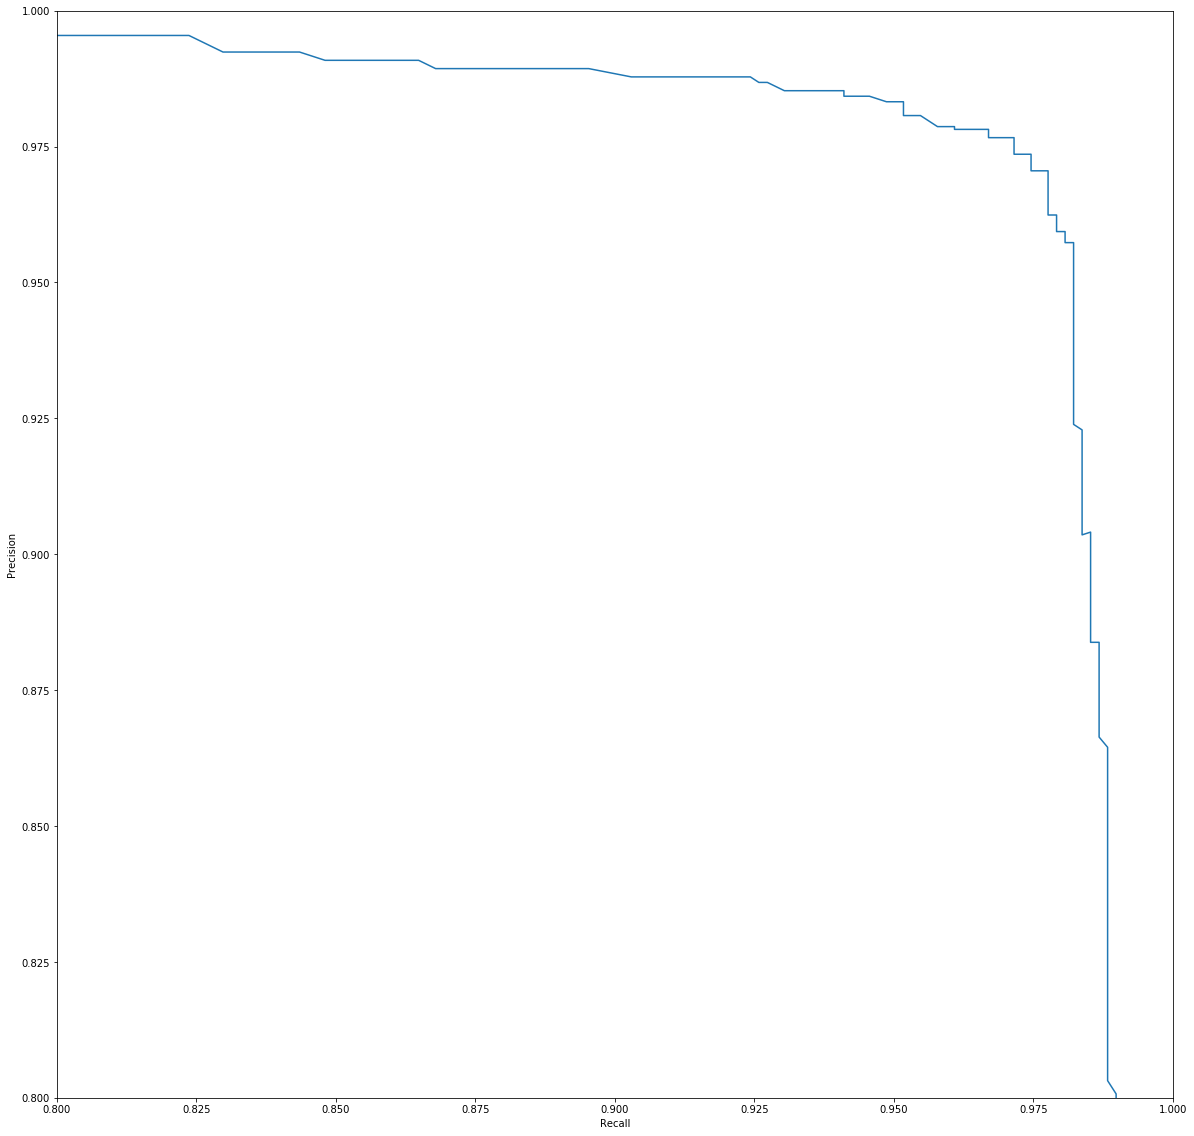

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from tools import read_predicted_boxes, read_ground_truth_boxes


def calculate_iou(prediction_box, gt_box):
    """Calculate intersection over union of single predicted and ground truth box.

    Args:
        prediction_box (np.array of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (np.array of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]

        returns:
            float: value of the intersection of union for the two boxes.
    """
    width_predict=prediction_box[2]-prediction_box[0]
    height_predict=prediction_box[3]-prediction_box[1]
    width_gt=gt_box[2]-gt_box[0]
    height_gt=gt_box[3]-gt_box[1]
    #Calculate the edge of the overlap
    width_overlap= min(prediction_box[0],prediction_box[2],gt_box[0],gt_box[2])+width_predict+width_gt-max(prediction_box[0],prediction_box[2],gt_box[0],gt_box[2])
    height_overlap=min(prediction_box[1],prediction_box[3],gt_box[1],gt_box[3])+height_predict+height_gt-max(prediction_box[1],prediction_box[3],gt_box[1],gt_box[3])
    #Calculate the IoU
    if width_overlap <= 0 or height_overlap <= 0:
        iou = 0
    else:
        iou=width_overlap*height_overlap/(width_predict*height_predict+width_gt*height_gt-width_overlap*height_overlap)
    assert iou >= 0 and iou <= 1
    return iou


def calculate_precision(num_tp, num_fp, num_fn):
    """ Calculates the precision for the given parameters.
        Returns 1 if num_tp + num_fp = 0

    Args:
        num_tp (float): number of true positives
        num_fp (float): number of false positives
        num_fn (float): number of false negatives
    Returns:
        float: value of precision
    """
    if num_tp + num_fp == 0:
        return 1
    else:
        return num_tp/(num_tp+num_fp)


def calculate_recall(num_tp, num_fp, num_fn):
    """ Calculates the recall for the given parameters.
        Returns 0 if num_tp + num_fn = 0
    Args:
        num_tp (float): number of true positives
        num_fp (float): number of false positives
        num_fn (float): number of false negatives
    Returns:
        float: value of recall
    """
    if num_tp + num_fn == 0:
        return 0
    else:
        return num_tp/(num_tp+num_fn)


def get_all_box_matches(prediction_boxes, gt_boxes, iou_threshold):
    """Finds all possible matches for the predicted boxes to the ground truth boxes.
        No bounding box can have more than one match.

        Remember: Matching of bounding boxes should be done with decreasing IoU order!

    Args:
        prediction_boxes: (np.array of floats): list of predicted bounding boxes
            shape: [number of predicted boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
        gt_boxes: (np.array of floats): list of bounding boxes ground truth
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
    Returns the matched boxes (in corresponding order):
        prediction_boxes: (np.array of floats): list of predicted bounding boxes
            shape: [number of box matches, 4].
        gt_boxes: (np.array of floats): list of bounding boxes ground truth
            objects with shape: [number of box matches, 4].
            Each row includes [xmin, xmax, ymin, ymax]
    """
    # Find all possible matches with a IoU >= iou threshold
    
    match_matrix=np.zeros([prediction_boxes.shape[0],gt_boxes.shape[0]])
    [row,column]=match_matrix.shape
    for i in range(row):
        for j in range(column):
            iou=calculate_iou(prediction_boxes[i,:],gt_boxes[j,:])
            if iou>= iou_threshold:
                match_matrix[i,j]=iou
    # Sort all matches on IoU in descending order
    match_row=[]
    match_column=[]
    #print('match_matrix',match_matrix)
    if match_matrix.size==1 and match_matrix>0:
        return prediction_boxes, gt_boxes
    elif match_matrix.size==0:
        return np.array([]), np.array([])
    else:
        while np.sum(match_matrix)>0:
            [index_r,index_c]=np.where(match_matrix==np.max(match_matrix))
#             print('match_matrix',match_matrix)
#             print('index_r',index_r)
            #if index_r.size>1:
            index_r= index_r[0]
            index_c=index_c[0]
            match_row.append(index_r)
            match_column.append(index_c)
            match_matrix[index_r,:]=0
            match_matrix[:,index_c]=0
                
    # Find all matches with the highest IoU threshold
        match_row=np.array(match_row)
        match_column=np.array(match_column)
        if match_row.size==0:
            return np.array([]), np.array([])
        else:
        #print('match_row',match_row,'match_column',match_column)
#         print('before, match_row',match_row,'match_column',match_column)
#         print( 'before',match_row.shape)
#         print( prediction_boxes[match_row,:].shape)
#         match_row=np.squeeze(np.array(match_row),axis=1)
#         match_column=np.squeeze(np.array(match_column),axis=1)
#         print( 'after',match_row.shape)
#         print('match_row',match_row,'match_column',match_column)
#        print( prediction_boxes[match_row,:].shape)
        #return np.squeeze(prediction_boxes[match_row,:],axis=1), np.squeeze(gt_boxes[match_column,:],axis=1)
            return prediction_boxes[match_row,:], gt_boxes[match_column,:]
    


def calculate_individual_image_result(prediction_boxes, gt_boxes, iou_threshold):
    """Given a set of prediction boxes and ground truth boxes,
       calculates true positives, false positives and false negatives
       for a single image.
       NB: prediction_boxes and gt_boxes are not matched!

    Args:
        prediction_boxes: (np.array of floats): list of predicted bounding boxes
            shape: [number of predicted boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
        gt_boxes: (np.array of floats): list of bounding boxes ground truth
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
    Returns:
        dict: containing true positives, false positives, true negatives, false negatives
            {"true_pos": int, "false_pos": int, false_neg": int}
    """
    match_prediction, match_gt = get_all_box_matches(prediction_boxes,gt_boxes,iou_threshold)
    TP=match_prediction.shape[0]
    FP=prediction_boxes.shape[0]-TP
    FN=gt_boxes.shape[0]-TP
    return {"true_pos":TP, "false_pos": FP, "false_neg": FN}


def calculate_precision_recall_all_images(
    all_prediction_boxes, all_gt_boxes, iou_threshold):
    """Given a set of prediction boxes and ground truth boxes for all images,
       calculates recall and precision over all images
       for a single image.
       NB: all_prediction_boxes and all_gt_boxes are not matched!

    Args:
        all_prediction_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all predicted bounding boxes for the given image
            with shape: [number of predicted boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
        all_gt_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all ground truth bounding boxes for the given image
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
    Returns:
        tuple: (precision, recall). Both float.
    """
    precision=0;recall=0
    #print('len(all_prediction_boxes)',len(all_prediction_boxes))
    for i in range(len(all_prediction_boxes)):
        res=calculate_individual_image_result(all_prediction_boxes[i],all_gt_boxes[i],iou_threshold)
        TP= res["true_pos"];FP=res["false_pos"];FN=res["false_neg"];
        #print('TP',TP,'FP',FP,'FN',FN)
        precision=precision+calculate_precision(TP,FP,FN)
        recall=recall+calculate_recall(TP,FP,FN)
    return precision/len(all_prediction_boxes), recall/len(all_prediction_boxes)
    


def get_precision_recall_curve(
    all_prediction_boxes, all_gt_boxes, confidence_scores, iou_threshold
):
    """Given a set of prediction boxes and ground truth boxes for all images,
       calculates the recall-precision curve over all images.
       for a single image.

       NB: all_prediction_boxes and all_gt_boxes are not matched!

    Args:
        all_prediction_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all predicted bounding boxes for the given image
            with shape: [number of predicted boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
        all_gt_boxes: (list of np.array of floats): each element in the list
            is a np.array containing all ground truth bounding boxes for the given image
            objects with shape: [number of ground truth boxes, 4].
            Each row includes [xmin, xmax, ymin, ymax]
        scores: (list of np.array of floats): each element in the list
            is a np.array containting the confidence score for each of the
            predicted bounding box. Shape: [number of predicted boxes]

            E.g: score[0][1] is the confidence score for a predicted bounding box 1 in image 0.
    Returns:
        precisions, recalls: two np.ndarray with same shape.
    """
    # Instead of going over every possible confidence score threshold to compute the PR
    # curve, we will use an approximation
    confidence_thresholds = np.linspace(0, 1, 500)
    # YOUR CODE HERE
    precisions = [] 
    recalls = []
    for i in confidence_thresholds:
        satisfied_prediction_boxes=[]
        #satisfied_gt_boxes=[]
        for j in range(len(confidence_scores)):
            tmp=np.where(confidence_scores[j]>=i)
            #print('chosen',tmp)
            #print(all_prediction_boxes[j][tmp])
            satisfied_prediction_boxes.append(all_prediction_boxes[j][tmp])
            #satisfied_gt_boxes.append(all_gt_boxes[j][tmp])
        #print('satisfied_prediction_boxes',satisfied_prediction_boxes)
        precision,recall=calculate_precision_recall_all_images(satisfied_prediction_boxes, all_gt_boxes, iou_threshold)
        precisions.append(precision);recalls.append(recall)
    #print('precision',precisions,'recall',recalls)
        
    return np.array(precisions), np.array(recalls)


def plot_precision_recall_curve(precisions, recalls):
    """Plots the precision recall curve.
        Save the figure to precision_recall_curve.png:
        'plt.savefig("precision_recall_curve.png")'

    Args:
        precisions: (np.array of floats) length of N
        recalls: (np.array of floats) length of N
    Returns:
        None
    """
    plt.figure(figsize=(20, 20))
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0.8, 1.0])
    plt.ylim([0.8, 1.0])
    plt.savefig("precision_recall_curve.png")


def calculate_mean_average_precision(precisions, recalls):
    """ Given a precision recall curve, calculates the mean average
        precision.

    Args:
        precisions: (np.array of floats) length of N
        recalls: (np.array of floats) length of N
    Returns:
        float: mean average precision
    """
    # Calculate the mean average precision given these recall levels.
    recall_levels = np.linspace(0, 1.0, 11)
    # YOUR CODE HERE
    precision_levels=np.zeros(recall_levels.shape)
    #Re-rank recalls and precisions from small to large
    precisions=precisions[np.argsort(recalls)]
    recalls=recalls[np.argsort(recalls)]
    for i in range(recall_levels.size):
        tmp=np.where(recalls>=recall_levels[i])[0]
        if tmp.size>0:
            precision_levels[i]=precisions[tmp[0]]
    average_precision = np.sum(precision_levels)/11
    return average_precision


def mean_average_precision(ground_truth_boxes, predicted_boxes):
    """ Calculates the mean average precision over the given dataset
        with IoU threshold of 0.5

    Args:
        ground_truth_boxes: (dict)
        {
            "img_id1": (np.array of float). Shape [number of GT boxes, 4]
        }
        predicted_boxes: (dict)
        {
            "img_id1": {
                "boxes": (np.array of float). Shape: [number of pred boxes, 4],
                "scores": (np.array of float). Shape: [number of pred boxes]
            }
        }
    """
    # DO NOT EDIT THIS CODE
    all_gt_boxes = []
    all_prediction_boxes = []
    confidence_scores = []

    for image_id in ground_truth_boxes.keys():
        pred_boxes = predicted_boxes[image_id]["boxes"]
        scores = predicted_boxes[image_id]["scores"]

        all_gt_boxes.append(ground_truth_boxes[image_id])
        all_prediction_boxes.append(pred_boxes)
        confidence_scores.append(scores)

    precisions, recalls = get_precision_recall_curve(
        all_prediction_boxes, all_gt_boxes, confidence_scores, 0.5)
    plot_precision_recall_curve(precisions, recalls)
    mean_average_precision = calculate_mean_average_precision(precisions, recalls)
    print("Mean average precision: {:.4f}".format(mean_average_precision))


if __name__ == "__main__":
    ground_truth_boxes = read_ground_truth_boxes()
    predicted_boxes = read_predicted_boxes()
    mean_average_precision(ground_truth_boxes, predicted_boxes)


In [2]:
from task2 import *
import numpy as np


def test_iou():
    print("="*80)
    print("Running tests for calculate_iou_individual_image")
    b1 = np.array([0, 0, 1, 1])
    b2 = np.array([1.0, 1.0, 2, 2])

    res = calculate_iou(b1, b2)
    ans = 0
    assert res == ans, "Expected {}, got: {}".format(ans, res)
    b1 = np.array([2, 1, 4, 3])
    b2 = np.array([1, 2, 3, 4])

    res = calculate_iou(b1, b2)
    ans = 1/7
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([0, 0, 1, 1])
    b2 = np.array([0, 0, 1, 1])
    res = calculate_iou(b1, b2)
    ans = 1.0
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([0, 0, 1, 1])
    b2 = np.array([0.5, 0.5, 1, 1])
    res = calculate_iou(b1, b2)
    ans = 0.25
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([5.5, 5.5, 8, 8])
    b2 = np.array([5.5, 3, 8, 4])
    res = calculate_iou(b1, b2)
    ans = 0.0
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([5.5, 5.5, 8, 8])
    b2 = np.array([3, 5.5, 4, 9])
    res = calculate_iou(b1, b2)
    ans = 0.0
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    b1 = np.array([522, 540, 576, 660])
    b2 = np.array([520, 540, 570, 655])
    res = round(calculate_iou(b1, b2), 5)
    ans = 0.82265
    assert res == ans, "Expected {}, got: {}".format(ans, res)


def test_precision():
    print("="*80)
    print("Running tests for calculate_precision")
    ans = 1
    res = calculate_precision(0, 0, 0)
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    res = calculate_precision(10, 20, 0)
    ans = 1/3
    assert res == ans, "Expected {}, got: {}".format(ans, res)


def test_recall():
    print("="*80)
    print("Running tests for calculate_recall")
    ans = 0
    res = calculate_recall(0, 0, 0)
    assert res == ans, "Expected {}, got: {}".format(ans, res)

    res = calculate_recall(10, 0, 30)
    ans = 1/4
    assert res == ans, "Expected {}, got: {}".format(ans, res)


def test_get_all_box_matches():
    print("="*80)
    print("Running tests for get_all_box_matches")
    b1 = np.array([
        [0, 0, 1, 1]
    ])
    b2 = np.array([
        [0, 0, 1, 1]
    ])
    res1, res2 = get_all_box_matches(b1, b2, 0.5)
    assert np.all(res1 == b1)
    assert np.all(res2 == b2)
    res1, res2 = get_all_box_matches(b1, b2, 1)
    assert np.all(res1 == b1)
    assert np.all(res2 == b2)

    b2 = np.array([
        [0, 0, 1, 1],
        [0.25, 0.25, 1, 1]
    ])
    res1, res2 = get_all_box_matches(b1, b2, 1)
    assert np.all(res1 == b1)
    assert np.all(res2 == b2[0:1])

    b2 = np.array([
        [0.25, 0.25, 1, 1],
        [0, 0, 1, 1]
    ])
    res1, res2 = get_all_box_matches(b1, b2, 1)
    assert np.all(res1 == b1)
    assert np.all(res2 == b2[1:2])

    res1, res2 = get_all_box_matches(np.array([]), np.array([]), 0.5)
    assert res1.size == 0
    assert res2.size == 0


def test_calculate_individual_image_result():
    print("="*80)
    print("Running tests for calculate_individual_image_result")
    b1 = np.array([
        [0, 0, 1, 1],
        [0.5, 0.5, 1.5, 1.5],
        [2, 2, 3, 3],
        [5.5, 5.5, 8, 8]
    ])
    b2 = np.array([
        [0, 0, 1, 1],
        [0, 0, 1.5, 1.5],
        [3, 3, 4, 4],
        [5, 5, 8, 8]
    ])
    np.random.shuffle(b1)
    np.random.shuffle(b2)
    ans1 = 2
    ans2 = 2
    ans3 = 2
    res = calculate_individual_image_result(b1, b2, 0.5)

    assert res["true_pos"] == ans1, "Expected {}, got: {}".format(
        ans1, res["true_pos"])
    assert res["false_pos"] == ans2, "Expected {}, got: {}".format(
        ans2, res["false_pos"])
    assert res["false_neg"] == ans3, "Expected {}, got: {}".format(
        ans3, res["false_neg"])


def test_calculate_precision_recall_all_images():
    print("="*80)
    print("Running tests for calculate_precision_recall_all_images")
    b1 = np.array([
        [0, 0, 1, 1],
        [0.5, 0.5, 1.5, 1.5],
        [2, 2, 3, 3],
        [5.5, 5.5, 8, 8]
    ])
    b2 = np.array([
        [0, 0, 1, 1],
        [0, 0, 1.5, 1.5],
        [3, 3, 4, 4],
        [5, 5, 8, 8]
    ])
    np.random.shuffle(b1)
    np.random.shuffle(b2)
    ans1 = 6/8
    ans2 = 6/8
    res1, res2 = calculate_precision_recall_all_images([b1, b2], [b2, b2], 0.5)
    assert res1 == ans1, "Expected {}, got: {}".format(ans1, res1)
    assert res2 == ans2, "Expected {}, got: {}".format(ans2, res2)


def test_get_precision_recall_curve():
    print("="*80)
    print("Running tests for get_precision_recall_curve")
    b1 = np.array([
        [0, 0, 1, 1],
        [0.5, 0.5, 1.5, 1.5],
        [2, 2, 3, 3],
        [5.5, 5.5, 8, 8]
    ])
    b2 = np.array([
        [0, 0, 1, 1],
        [0, 0, 1.5, 1.5],
        [3, 3, 4, 4],
        [5, 5, 8, 8]
    ])
    s = np.array([0.4, 0.7, 0.6, 0.9])
    ans1 = 404
    ans2 = 243
    res1, res2 = get_precision_recall_curve([b1, b2], [b2, b2], [s, s], 0.5)
    res1 = int(res1.sum())
    res2 = int(res2.sum())
    assert res1 == ans1, "Expected {}, got: {}".format(ans1, res1)
    assert res2 == ans2, "Expected {}, got: {}".format(ans2, res2)


def test_mean_average_precision():
    print("="*80)
    print("Running tests for calculate_mean_average_precision")
    p = np.array([0.19620253, 0.38137083, 0.65555556, 0.81179423, 0.88598901,
                  0.93198263, 0.95386905, 0.9695586, 0.98397436, 1.])
    r = np.array([0.99237805, 0.99237805, 0.98932927, 0.98628049, 0.98323171,
                  0.98170732, 0.97713415, 0.97103659, 0.93597561, 0.])

    res1 = calculate_mean_average_precision(p, r)
    ans1 = 0.89598
    assert round(res1, 5) == ans1, "Expected {}, got: {}".format(ans1, res1)


if __name__ == "__main__":
    test_iou()
    test_precision()
    test_recall()
    test_get_all_box_matches()
    test_calculate_individual_image_result()
    test_calculate_precision_recall_all_images()
    test_get_precision_recall_curve()
    test_mean_average_precision()
    print("="*80)
    print("All tests OK.")

Running tests for calculate_iou_individual_image
Running tests for calculate_precision
Running tests for calculate_recall
Running tests for get_all_box_matches
Running tests for calculate_individual_image_result
Running tests for calculate_precision_recall_all_images
Running tests for get_precision_recall_curve
Running tests for calculate_mean_average_precision
All tests OK.


In [ ]:
b2 = np.array([
        [0, 0, 1, 1],
        [0.25, 0.25, 1, 1]
    ])


In [ ]:
precisions

In [ ]:
np.argmax(b2)

In [ ]:
[r,c]=np.where(b2==np.max(b2))

In [ ]:
print(b2[r,c])

In [ ]:
b2[r,:]

In [53]:
p = np.array([0.19620253, 0.38137083, 0.65555556, 0.81179423, 0.88598901,
              0.93198263, 0.95386905, 0.9695586, 0.98397436, 1.])
r = np.array([0.99237805, 0.99237805, 0.98932927, 0.98628049, 0.98323171,
              0.98170732, 0.97713415, 0.97103659, 0.93597561, 0.])

res1 = calculate_mean_average_precision(p, r)
ans1 = 0.89598
assert round(res1, 5) == ans1, "Expected {}, got: {}".format(ans1, res1)

[0.         0.93597561 0.97103659 0.97713415 0.98170732 0.98323171
 0.98628049 0.98932927 0.99237805 0.99237805]


TypeError: 'numpy.ndarray' object is not callable

In [54]:
print(r[np.argsort(r)])
print(p[np.argsort(r)])

[0.         0.93597561 0.97103659 0.97713415 0.98170732 0.98323171
 0.98628049 0.98932927 0.99237805 0.99237805]
[1.         0.98397436 0.9695586  0.95386905 0.93198263 0.88598901
 0.81179423 0.65555556 0.19620253 0.38137083]


In [75]:
r1=
p1=p[np.argsort(r)]
max_rank=np.argsort(-p1)
print(max_rank)

[0 1 2 3 4 5 6 7 9 8]


In [73]:
np.argmax(max_rank)

8

In [71]:
p2=np.zeros(p1.shape)
p2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [76]:
p2[:np.argmax(max_rank)]=p1[np.argmax(max_rank)]

In [77]:
p2

array([0.19620253, 0.19620253, 0.19620253, 0.19620253, 0.19620253,
       0.19620253, 0.19620253, 0.19620253, 0.        , 0.        ])